Import the necessary libraries

In [1]:
!pip install transformers
!pip install ipywidgets
!pip install pytorch-lightning==1.5.10
!pip install nvidia-ml-py3
!pip install neptune-client
!pip install lightning-bolts
!pip install torchmetrics

  Using cached pytorch_lightning-1.5.10-py3-none-any.whl (527 kB)
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.9.5
    Uninstalling pytorch-lightning-1.9.5:
      Successfully uninstalled pytorch-lightning-1.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lightning-bolts 0.7.0 requires pytorch-lightning<2.0.0,>1.7.0, but you have pytorch-lightning 1.5.10 which is incompatible.
  Using cached pytorch_lightning-1.9.5-py3-none-any.whl (829 kB)
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.5.10
    Uninstalling pytorch-lightning-1.5.10:
      Successfully uninstalled pytorch-lightning-1.5.10


In [2]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model, Wav2Vec2Config
import torch
from transformers.models.wav2vec2.modeling_wav2vec2 import Wav2Vec2FeatureEncoder, Wav2Vec2NoLayerNormConvLayer, Wav2Vec2LayerNormConvLayer
from torch import nn
from transformers.activations import ACT2FN
import ipywidgets
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import csv
import torchaudio
import torchtext
import pytorch_lightning as pl
import nvidia_smi
from pytorch_lightning.loggers.neptune import NeptuneLogger
from pytorch_lightning.loggers import NeptuneLogger
from IPython.display import display, HTML
from dataclasses import dataclass, field
from torch.utils.data import DataLoader
from typing import Any, Dict, List, Optional, Union
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
from torchmetrics import Accuracy
from torchmetrics import F1Score
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
import numpy as np
import contextlib


/home/cslab03/anaconda3/envs/coEnv/lib/python3.9/site-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
/home/cslab03/anaconda3/envs/coEnv/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/cslab03/anaconda3/envs/coEnv/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdi

Verify if the GPU is working

In [3]:
!nvidia-smi

Wed Nov 15 21:47:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:B3:00.0  On |                  Off |
| 53%   62C    P5    26W / 140W |    494MiB / 16376MiB |     27%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
print(f"Pytorch Lightning Version: {pl.__version__}")
nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
print(f"Device name: {nvidia_smi.nvmlDeviceGetName(handle)}")

Pytorch Lightning Version: 1.9.5


Device name: b'NVIDIA RTX A4000'


Define hyperparameters

In [5]:
version = "wav2vec2-sound_sismic_train" #@param {type: "string"}
lr = 1e-5#@param {type: "number"}
w_decay = 1e-4#@param {type: "number"}
bs = 16#@param {type: "integer"}
accum_grads = 4#@param {type: "integer"}
patience = 15#@param {type: "integer"}
max_epochs = 300#@param {type: "integer"}
# warmup_steps = 1000#@param {type: "integer"}
hold_epochs = 20#@param {type: "integer"}
pretrained = "facebook/wav2vec2-base-960h"#@param {type: "string"}
wav2vec2_processor = "facebook/wav2vec2-base-960h"#@param {type: "string"}
freeze_finetune_updates = 0#@param {type: "integer"}
warmup_epochs = 40#@param {type: "integer"}
apply_mask=False#@param {type: "boolean"}
mask_time_length= 1#@param {type: "integer"}, era 1

# Define hyperparameters
hparams = {"version": version,
          "lr": lr,
          "w_decay": w_decay,
          "bs": bs,
          "patience": patience,
          "hold_epochs":hold_epochs,
          "accum_grads": accum_grads,
          "pretrained":pretrained,
          "wav2vec2_processor": wav2vec2_processor,
          "freeze_finetune_updates":freeze_finetune_updates,
          "warmup_epochs":warmup_epochs,
          "apply_mask":apply_mask,
          "mask_time_length":mask_time_length,
          "max_epochs": max_epochs}
hparams

{'version': 'wav2vec2-sound_sismic_train',
 'lr': 1e-05,
 'w_decay': 0.0001,
 'bs': 16,
 'patience': 15,
 'hold_epochs': 20,
 'accum_grads': 4,
 'pretrained': 'facebook/wav2vec2-base-960h',
 'wav2vec2_processor': 'facebook/wav2vec2-base-960h',
 'freeze_finetune_updates': 0,
 'warmup_epochs': 40,
 'apply_mask': False,
 'mask_time_length': 1,
 'max_epochs': 300}

Use the original processor from Wav2Vec2

In [6]:
processor = Wav2Vec2Processor.from_pretrained(hparams["wav2vec2_processor"], return_attention_mask=True)

In [7]:
print(processor)

Wav2Vec2Processor:
- feature_extractor: Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": true,
  "sampling_rate": 16000
}

- tokenizer: PreTrainedTokenizer(name_or_path='facebook/wav2vec2-base-960h', vocab_size=32, model_max_len=9223372036854775807, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'})


In [8]:
model = Wav2Vec2Model.from_pretrained(hparams["pretrained"])

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
print(model)

Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [10]:
print(model.feature_extractor)

Wav2Vec2FeatureEncoder(
  (conv_layers): ModuleList(
    (0): Wav2Vec2GroupNormConvLayer(
      (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      (activation): GELUActivation()
      (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
    )
    (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
  )
)


DO THE TRAIN-TEST SPLIT

In [11]:
#from sklearn.model_selection import train_test_split
#import os
#import shutil
#import librosa

# #Define la ruta de la carpeta que contiene los archivos de audio
#input_folder = '/media/cslab03/TOSHIBA EXT/TESIS/DataSet/AudioSismig1/'

# #Lista todos los archivos de la carpeta
#files = [os.path.join(input_folder, file) for file in os.listdir(input_folder)]

# #Define las proporciones para train, test y validation sets
#train_ratio = 0.7
#test_ratio = 0.15
#validation_ratio = 0.15

# ##Divide los datos en train, test y validation sets
#train_files, temp_files = train_test_split(files, test_size=1 - train_ratio)
#test_files, validation_files = train_test_split(temp_files, test_size=validation_ratio / (test_ratio + validation_ratio))

 #Define las carpetas de salida
#output_folder = './data1/'
#os.makedirs(os.path.join(output_folder, 'train'), exist_ok=True)
#os.makedirs(os.path.join(output_folder, 'test'), exist_ok=True)
#os.makedirs(os.path.join(output_folder, 'validation'), exist_ok=True)


 #Copia los archivos a las carpetas correspondientes
#for file in train_files:
#    if 'BHZ' in file:    
#        try:
#            audio, _ = librosa.load(file, sr=None)
#            shutil.copy(file, os.path.join(output_folder, 'train'))
#        except Exception as e:
#            print(e)
#            print(file)
#    else:
#        continue
    
#for file in test_files:
#    if 'BHZ' in file:
#        try:
#            audio, _ = librosa.load(file, sr=None)
#            shutil.copy(file, os.path.join(output_folder, 'test'))
#        except Exception as e:
#            print(e)
#            print(file)
#    else:
#        continue
    
#for file in validation_files:
#    if 'BHZ' in file:
#        try:
#            audio, _ = librosa.load(file, sr=None)
#            shutil.copy(file, os.path.join(output_folder, 'validation'))
#        except Exception as e:
#            print(e)
#            print(file)
#    else:
#        continue

#print("Data split completed.")


In [12]:
# from sklearn.model_selection import train_test_split
# import os
# import shutil
# import librosa

# # Define la ruta de la carpeta que contiene los archivos de audio
# input_folder = '/home/cslab03/Desktop/QuakeWavNet/test_audios/'

# # Lista todos los archivos de la carpeta
# files = [os.path.join(input_folder, file) for file in os.listdir(input_folder)]

# # Filtra los archivos 'LP' y 'VT'
# lp_files = [file for file in files if '_00.wav' in file]
# vt_files = [file for file in files if '_01.wav' in file]

# print(f'LP files: {len(lp_files)}')
# print(f'VT files: {len(vt_files)}')
# # Define las proporciones para train, test y validation sets
# train_ratio = 0.7
# test_ratio = 0.15
# validation_ratio = 0.15

# # Divide los datos en train, test y validation sets
# lp_train_files, lp_temp_files = train_test_split(lp_files, test_size=1 - train_ratio)
# lp_test_files, lp_validation_files = train_test_split(lp_temp_files, test_size=validation_ratio / (test_ratio + validation_ratio))
# print(f'LP train files: {len(lp_train_files)}')
# print(f'LP test files: {len(lp_test_files)}')
# print(f'LP validation files: {len(lp_validation_files)}')

# vt_train_files, vt_temp_files = train_test_split(vt_files, test_size=1 - train_ratio)
# vt_test_files, vt_validation_files = train_test_split(vt_temp_files, test_size=validation_ratio / (test_ratio + validation_ratio))
# print(f'VT train files: {len(vt_train_files)}')
# print(f'VT test files: {len(vt_test_files)}')
# print(f'VT validation files: {len(vt_validation_files)}')


# # Define las carpetas de salida
# output_folder = './data2/'
# os.makedirs(os.path.join(output_folder, 'train'), exist_ok=True)
# os.makedirs(os.path.join(output_folder, 'test'), exist_ok=True)
# os.makedirs(os.path.join(output_folder, 'validation'), exist_ok=True)

# # Copia los archivos 'LP' a las carpetas correspondientes
# for file in lp_train_files:
#     try:
#         audio, _ = librosa.load(file, sr=None)
#         shutil.copy(file, os.path.join(output_folder, 'train'))
#     except Exception as e:
#         print(e)
#         print(file)

# for file in lp_test_files:
#     try:
#         audio, _ = librosa.load(file, sr=None)
#         shutil.copy(file, os.path.join(output_folder, 'test'))
#     except Exception as e:
#         print(e)
#         print(file)

# for file in lp_validation_files:
#     try:
#         audio, _ = librosa.load(file, sr=None)
#         shutil.copy(file, os.path.join(output_folder, 'validation'))
#     except Exception as e:
#         print(e)
#         print(file)

# # Copia los archivos 'VT' a las carpetas correspondientes
# for file in vt_train_files:
#     try:
#         audio, _ = librosa.load(file, sr=None)
#         shutil.copy(file, os.path.join(output_folder, 'train'))
#     except Exception as e:
#         print(e)
#         print(file)

# for file in vt_test_files:
#     try:
#         audio, _ = librosa.load(file, sr=None)
#         shutil.copy(file, os.path.join(output_folder, 'test'))
#     except Exception as e:
#         print(e)
#         print(file)

# for file in vt_validation_files:
#     try:
#         audio, _ = librosa.load(file, sr=None)
#         shutil.copy(file, os.path.join(output_folder, 'validation'))
#     except Exception as e:
#         print(e)
#         print(file)


In [13]:
import torch
import torchaudio
from transformers import Wav2Vec2Processor
from transformers import AutoFeatureExtractor

class ANSYN_Dataset_SE(torch.utils.data.Dataset):

    def __init__(self, filenames, audio_path):
        self.filenames = [filename for filename in filenames if not any(substring in filename for substring in ['TRBA', 'EXPL', 'VLP', 'TRESP','HB'])]
        self.audio_path = audio_path
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(hparams["pretrained"])
    
    def preprocess_function(self, audio_arrays):        
        inputs = self.feature_extractor(
            audio_arrays, sampling_rate=self.feature_extractor.sampling_rate, max_length=16000, truncation=True
        )
        return inputs

    def normalize_layer(self, feats):
        with torch.no_grad():
            feats = torch.nn.functional.layer_norm(feats, feats.shape)
        return feats

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        # Intenta cargar el archivo de audio
        feats, _ = torchaudio.load(self.filenames[index])

        # Asigna una etiqueta de destino basada en el nombre del archivo
        if 'LP' in self.filenames[index]:
            target = torch.tensor(int('00')).long() 
        elif 'VT' in self.filenames[index]:
            target = torch.tensor(int('01')).long()
        else:
            # Si las etiquetas están codificadas en el nombre del archivo
            target = torch.tensor(int(self.filenames[index][-6:-4])).long()

        feats = self.normalize_layer(feats)
        feats = self.preprocess_function(feats.numpy())
        feats = torch.tensor(feats.input_values).float()
        feats = feats.squeeze()
        
        
        
        
        return {"input_values": feats, "label": target}



In [14]:
@dataclass
class DataCollatorWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None
@dataclass
class DataCollatorWithPadding:
     """
     Data collator that will dynamically pad the inputs received.
     Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
             The processor used for proccessing the data.
         padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
             Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
             among:
             * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
               sequence if provided).
             * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
               maximum acceptable input length for the model if that argument is not provided.
             * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
               different lengths).
         max_length (:obj:`int`, `optional`):
             Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
         max_length_labels (:obj:`int`, `optional`):
             Maximum length of the ``labels`` returned list and optionally padding length (see above).
         pad_to_multiple_of (:obj:`int`, `optional`):
             If set will pad the sequence to a multiple of the provided value.
             This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
             7.5 (Volta).
     """
     processor: Wav2Vec2Processor
     padding: Union[bool, str] = True
     max_length: Optional[int] = None
     max_length_labels: Optional[int] = None
     pad_to_multiple_of: Optional[int] = None
     pad_to_multiple_of_labels: Optional[int] = None

     def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
                
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["label"]} for feature in features]
        batch = self.processor.pad(
             input_features,
             padding=self.padding,
             max_length=self.max_length,
             pad_to_multiple_of=self.pad_to_multiple_of,
             return_tensors="pt",
         )
        #print('batch', batch)
        with self.processor.as_target_processor(): labels_batch = self.processor.pad( label_features, padding=True,max_length=self.max_length_labels,pad_to_multiple_of=self.pad_to_multiple_of_labels,return_tensors="pt",)
        #print('labels_batch', labels_batch)

        labels = labels_batch["input_ids"]

        batch["label"] = labels

        return batch

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [16]:
from pytorch_lightning.utilities.types import EVAL_DATALOADERS


class SismgDataModule(pl.LightningDataModule):
    def __init__(self, audio_path,list_dir, total_kfold, batch_size, data_collator):
        super().__init__()
        self.audio_path = audio_path
        self.file_dir = list_dir
        self.total_kfold = total_kfold
        self.batch_size = batch_size
        self.data_collator = data_collator
        self.folds = None
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
        self.labels = None
        self.weights = ()
        self.set_folds()
    

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          collate_fn = self.data_collator,
                          shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          collate_fn = self.data_collator,
                          shuffle=False, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                          collate_fn = self.data_collator,
                          shuffle=False, num_workers=4)
        
    def predict_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                          collate_fn = self.data_collator,
                          shuffle=False, num_workers=4)

    def setup(self, fold, stage=None):
        file_dir = []
        for file in self.file_dir:
            if '_LP.' in file:
                file = file.replace('_LP', '_00')
            elif '_VT.' in file:
                file = file.replace('_VT', '_01')
            else:
                continue
            file_dir.append(file)
        train_index, val_index = train_test_split(self.folds[fold][0], test_size=0.2, random_state=42, stratify=[int(file_dir[file][-6:-4]) for file in self.folds[fold][0]])
        
        train_dir = [self.file_dir[file]for file in train_index]
        val_dir = [self.file_dir[file]for file in val_index]
        test_dir = [self.file_dir[file]for file in self.folds[fold][1]]
        
        self.train_dataset = ANSYN_Dataset_SE(train_dir, self.audio_path)
        self.val_dataset = ANSYN_Dataset_SE(val_dir, self.audio_path)
        self.test_dataset = ANSYN_Dataset_SE(test_dir, self.audio_path)
        self.weights = self.weights_labels()
            
    def set_folds(self):
        self.folds = []
        file_dir = []
        for file in self.file_dir:
            if '_LP.' in file:
                file = file.replace('_LP', '_00')
            elif '_VT.' in file:
                file = file.replace('_VT', '_01')
            else:
                continue
            file_dir.append(file)
        kfold = StratifiedKFold(n_splits=self.total_kfold, shuffle=True, random_state=42)
        kfold_split = kfold.split(self.file_dir, [int(file[-6:-4]) for file in file_dir])
        for fold in range(0,kfold.get_n_splits()):
            print(f'-------------Fold: {fold+1}----------------')
            self.folds.append(next(kfold_split))
            print(self.folds[fold])
    
    def weights_labels(self):
        classes_train = {}
        classes_val = {}
        classes_test = {}
        for data in self.train_dataset:
            label = data["label"].item()
                    
            if label in classes_train:
                classes_train[label] += 1
            else:
                classes_train[label] = 1
                
        for data in self.val_dataset:
            label = data["label"].item()
                    
            if label in classes_val:
                classes_val[label] += 1
            else:
                classes_val[label] = 1

        for data in self.test_dataset:
            label = data["label"].item()
                    
            if label in classes_test:
                classes_test[label] += 1
            else:
                classes_test[label] = 1

        classes_train = dict(sorted(classes_train.items(), key=lambda x: x[0]))
        classes_val = dict(sorted(classes_val.items(), key=lambda x: x[0]))
        classes_test = dict(sorted(classes_test.items(), key=lambda x: x[0]))
        classes_weights_train = [round(len(self.train_dataset) / (len(classes_train) * classes_train[class_id]), 4) for class_id in classes_train]
        classes_weights_train = torch.FloatTensor(classes_weights_train).to('cuda')

        classes_weights_val = [round(len(self.val_dataset) / (len(classes_val) * classes_val[class_id]), 4) for class_id in classes_val]
        classes_weights_val = torch.FloatTensor(classes_weights_val).to('cuda')

        classes_weights_test = [round(len(self.test_dataset) / (len(classes_test) * classes_test[class_id]), 4) for class_id in classes_test]
        classes_weights_test = torch.FloatTensor(classes_weights_test).to('cuda')
        
        
        self.labels = classes_train.keys()
        self.labels = list(self.labels)
        
        return classes_weights_train, classes_weights_val, classes_weights_test
        


In [17]:
audio_path = '/home/cslab03/Desktop/test2/AudioSismig1/'

In [18]:
files = [os.path.join(audio_path, file) for file in os.listdir(audio_path)]
files[0]

'/home/cslab03/Desktop/test2/AudioSismig1/2e55d06a9ef7dcd44da6bf9fea6c372e_BDF_BTAM_LP.wav'

In [19]:
import os
import librosa

list_dir = []
lp_count = 0
vt_count = 0

for file in files:
    if 'BHZ' in file:
        try:
            audio, _ = torchaudio.load(file)
            list_dir.append(file)
        except Exception as e:
            print(e)
            print(file)

list_dir = [filename for filename in list_dir if not any(substring in filename for substring in ['TRBA', 'EXPL', 'VLP', 'TRESP','HB'])]

print(len(list_dir))


20459


In [20]:
data_collator = DataCollatorWithPadding(processor=processor,
                                        #max_length=188,
                                        padding=True)

In [21]:
dataset = SismgDataModule(audio_path=audio_path, list_dir=list_dir, total_kfold=5, batch_size=hparams["bs"], data_collator=data_collator)

-------------Fold: 1----------------
(array([    1,     2,     4, ..., 20456, 20457, 20458]), array([    0,     3,    13, ..., 20442, 20453, 20454]))
-------------Fold: 2----------------
(array([    0,     1,     3, ..., 20456, 20457, 20458]), array([    2,     7,    10, ..., 20446, 20449, 20455]))
-------------Fold: 3----------------
(array([    0,     1,     2, ..., 20454, 20455, 20458]), array([    6,     8,    15, ..., 20447, 20456, 20457]))
-------------Fold: 4----------------
(array([    0,     2,     3, ..., 20456, 20457, 20458]), array([    1,     4,    11, ..., 20450, 20451, 20452]))
-------------Fold: 5----------------
(array([    0,     1,     2, ..., 20455, 20456, 20457]), array([    5,     9,    18, ..., 20444, 20448, 20458]))


In [22]:
n_classes = 2
f1 = F1Score(num_classes=n_classes, average='weighted', task='multiclass')
accuracy = Accuracy(num_classes=n_classes,task='multiclass')

In [23]:
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics import ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import io
import torchvision
from transformers import Wav2Vec2Tokenizer
from sklearn.manifold import TSNE
from torch.nn import CrossEntropyLoss


In [24]:
from pytorch_lightning.trainer.supporters import CombinedLoader
import itertools


In [25]:
# # Define hyperparameters
# grid = {  "lr": [1e-5, 1e-4, 1e-3],
#           'module__n_neurons': [32,64,128],
#           'weight_decay': [1e-3, 1e-4],
#           }


# # Combina los valores de la cuadrícula en todas las combinaciones posibles
# combinations = list(itertools.product(*grid.values()))
# print(f"Total de combinaciones: {combinations}")
# print(f"Total de combinaciones: {len(combinations)}")

In [52]:
from typing import Any, List


class Wav2Vec2_sound_detection(pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__()

        self.hparams.update(hparams)

        self.freeze_finetune_updates = hparams["freeze_finetune_updates"]
        
        #self.params = params       
                
        self.train_losses = [] 
        self.val_losses = []
        self.val_f1_scores = []
        self.test_f1_scores = []
        self.labels = 2
        self.embeddings = []
        self.confussion_matrix = None
        self.all_preds = None
        self.all_targets = None
        self.softs_values = None
        
        self.classes_weights_train, self.classes_weights_val, self.classes_weights_test = dataset.weights
        
        self.model = Wav2Vec2Model.from_pretrained(hparams["pretrained"]).to('cuda')
        self.processor = Wav2Vec2Processor.from_pretrained(hparams["pretrained"])
        
        num_labels = 2
        
        self.classification_head = torch.nn.Sequential(
            torch.nn.Linear(self.model.config.hidden_size, 256),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(p=0.1),  
             torch.nn.Linear(256, 256),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(p=0.1),  
            torch.nn.Linear(256, num_labels),
        )

        # self.model.feature_extractor._freeze_parameters()

        # # # freeze base-model
        # for param in self.model.parameters():
        #     param.requires_grad = False

        
        self.logger_initialized = False
    
    
    
    def initialize_logger(self, logger):
        self.logger = logger
        self.logger_initialized = True

    def forward(self, samples, attention_mask=None):
        #ft = self.freeze_finetune_updates <= self.trainer.global_step
        input_dict = self.processor(samples['input_values'].squeeze(), return_tensors="pt", padding=True, attention_mask=samples['attention_mask'], sampling_rate=self.processor.feature_extractor.sampling_rate)
        input_ids = input_dict.input_values.squeeze().to('cuda')
        outputs = self.model(input_ids, attention_mask=attention_mask)
        last_hidden_states = outputs.last_hidden_state
        pooled_output = torch.mean(last_hidden_states, dim=1)
        
        logits = self.classification_head(pooled_output)       
        
        return logits, pooled_output

            
        
    def training_step(self, train_batch, batch_idx):
        
        y_value = train_batch.pop("label")
                    
        log_softs, _ = self.forward(train_batch)
        
        loss = CrossEntropyLoss(weight=self.classes_weights_train)
        
        train_loss = loss(log_softs, y_value)
        

        self.log('loss_step', train_loss, on_step=True, prog_bar=True)
        
        
        #self.logger.log_metrics({'train_loss': loss.item()}, step=self.global_step)

        return train_loss

    def training_epoch_end(self, outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean()
        

        self.log("train_loss", loss, prog_bar=True)
        self.train_losses.append(loss.item())
        
        self.logger.log_metrics({'train_loss_epoch': loss.item()}, step=self.current_epoch)
        

    def validation_step(self, val_batch, batch_idx):

        y_value = val_batch.pop("label")
        
                
        log_softs, _ = self.forward(val_batch)
        preds = torch.argmax(log_softs, dim=1)

        val_acc = accuracy(preds.cpu(), y_value.cpu())
        val_f1 = f1(preds.cpu(), y_value.cpu())
        
        loss = CrossEntropyLoss(weight=self.classes_weights_val)
        
        val_loss = loss(log_softs, y_value)
        

        self.log('val_acc', val_acc, prog_bar=True)
        self.log('val_f1', val_f1, prog_bar=True)
        self.log('val_loss', val_loss, prog_bar=True)
        
        
        
        #self.logger.log_metrics({'val_acc': val_acc, 'val_f1': val_f1, 'val_loss': val_loss.item()}, step=self.global_step)

        return {"val_acc_step": val_acc, "val_f1_step": val_f1, "val_loss_step": val_loss}

    
    def validation_epoch_end(self, outputs):
        acc_mean = torch.stack([x['val_acc_step'] for x in outputs]).mean()
        f1_mean = torch.stack([x['val_f1_step'] for x in outputs]).mean()
        loss_mean = torch.stack([x['val_loss_step'] for x in outputs]).mean()
                

        self.log("val_acc", acc_mean, prog_bar=True)
        self.log("val_f1", f1_mean, prog_bar=True)
        self.log("val_loss", loss_mean, prog_bar=True)

        self.val_f1_scores.append(f1_mean)
        self.val_losses.append(loss_mean.item())
        
        self.logger.log_metrics({'val_acc_epoch': acc_mean, 'val_f1_epoch': f1_mean, 'val_loss_epoch': loss_mean.item()}, step=self.current_epoch)
        
    #import torch.functional as F
    
    """def validation_epoch_end(self, outputs):
        acc_mean = torch.stack([x['val_acc_step'] for x in outputs]).mean()
        f1_mean = torch.stack([x['val_f1_step'] for x in outputs]).mean()
        loss_mean = torch.stack([x['val_loss_step'] for x in outputs]).mean()

        self.log("val_acc", acc_mean, prog_bar=True)
        self.log("val_f1", f1_mean, prog_bar=True)
        self.log("val_loss", loss_mean, prog_bar=True)"""

    def test_step(self, test_batch, batch_idx):

        y_value = test_batch.pop("label")
        
        
        log_softs, pooled_output = self.forward(test_batch)
        softs = F.softmax(log_softs,dim=1)
        preds = torch.argmax(log_softs, dim=1)

        test_acc = accuracy(preds.cpu(), y_value.cpu())
        test_f1 = f1(preds.cpu(), y_value.cpu())
        
        loss = CrossEntropyLoss(weight=self.classes_weights_test)
        test_loss = loss(log_softs, y_value)
                
        embedding = pooled_output.detach().cpu().numpy().tolist()
        self.embeddings.extend(embedding)

        self.log('test_acc', test_acc, prog_bar=True)
        self.log('test_f1', test_f1, prog_bar=True)
        self.log('test_loss', test_loss, prog_bar=True)
        
        self.logger.log_metrics({'test_acc': test_acc, 'test_f1': test_f1, 'test_loss': test_loss.item()}, step=self.global_step)
        
        return {"test_acc_step": test_acc, "test_f1_step": test_f1,  "test_loss_step": test_loss, "preds": preds, "y_value": y_value, 'softs': softs}

    def test_epoch_end(self, outputs):
        acc_mean = torch.stack([x['test_acc_step'] for x in outputs]).mean()
        f1_mean = torch.stack([x['test_f1_step'] for x in outputs]).mean()
        loss_mean = torch.stack([x['test_loss_step'] for x in outputs]).mean()
        

        self.log("test_acc", acc_mean, prog_bar=True)
        self.log("test_f1", f1_mean, prog_bar=True)
        self.log("test_loss", loss_mean, prog_bar=True)
        
        self.test_f1_scores.append(f1_mean)
        self.all_preds = torch.cat([x['preds'] for x in outputs])
        self.all_targets = torch.cat([x['y_value'] for x in outputs])
        self.softs_values = torch.cat([x['softs'] for x in outputs])
        
        #self.logger.log_metrics({'test_acc_epoch': acc_mean, 'test_f1_epoch': f1_mean, 'test_loss_epoch': loss_mean.item()}, step=self.current_epoch)
    
    
    
    def configure_optimizers(self):

        optimizer = torch.optim.Adam(self.parameters(),
                         lr=self.hparams['lr'],
                         betas=(0.9,0.98),
                         eps=1e-6,
                         weight_decay=self.hparams['w_decay'])

        scheduler = LinearWarmupCosineAnnealingLR(optimizer,
                                                  eta_min=0,
                                                  warmup_start_lr=self.hparams["lr"],
                                                  warmup_epochs=self.hparams["warmup_epochs"],
                                                  max_epochs=self.hparams["max_epochs"])

        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [53]:
all_preds = None
all_targets = None
all_softs = None
for kfold in range(0,dataset.total_kfold):
    
    dataset.setup(fold=kfold, stage=None)

    logger = TensorBoardLogger("logs/metrics/", name="model_1")
    pl_model= Wav2Vec2_sound_detection(hparams=hparams, logger = logger)
    checkpoint_path = f'/home/cslab03/Desktop/test2/Results/model_{kfold}_{kfold}/'
    checkpoint_dir = os.path.dirname(os.path.abspath(checkpoint_path))
    os.makedirs(checkpoint_path, exist_ok=True)
    print(f'Files in {checkpoint_path}: {os.listdir(checkpoint_path)}')
    print(f'Saving checkpoints to {checkpoint_path}')
    checkpoint_callback = pl.callbacks.ModelCheckpoint(filename=f'model_{kfold}-{hparams["version"]}',
                                                    dirpath=checkpoint_path,
                                                    save_top_k=1,
                                                    verbose = True,
                                                    monitor="val_f1", mode="max")
    early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_f1", patience=hparams["patience"], mode='max')
    early_stop_callback_1 = pl.callbacks.EarlyStopping(monitor="val_loss", patience=hparams["patience"], mode='max')
    callbacks_list = [early_stop_callback, early_stop_callback_1]
    lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='step')
    trainer = pl.Trainer(gpus=1,
                        precision=16,
                        logger=logger,
                        num_sanity_val_steps=0,
                        accumulate_grad_batches=hparams["accum_grads"],
                        enable_checkpointing=True,
                        callbacks=callbacks_list + [lr_monitor, checkpoint_callback],
                        max_epochs=300)

    trainer.fit(pl_model, dataset.train_dataloader(), dataset.val_dataloader())
    
    trainer.test(dataloaders=dataset.test_dataloader())
    
    if all_preds is None:
        all_preds = pl_model.all_preds
    else:
        all_preds = torch.cat([all_preds, pl_model.all_preds])
    
    if all_targets is None:
        all_targets = pl_model.all_targets
    else:
        all_targets = torch.cat([all_targets, pl_model.all_targets])
        
    if all_softs is None:
        all_softs = pl_model.softs_values
    else:
        all_softs = torch.cat([all_softs, pl_model.softs_values])
    

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/cslab03/anaconda3/envs/coEnv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_

Files in /home/cslab03/Desktop/test2/Results/model_0_0/: []
Saving checkpoints to /home/cslab03/Desktop/test2/Results/model_0_0/


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 205: 'val_f1' reached 0.87078 (best 0.87078), saving model to '/home/cslab03/Desktop/test2/Results/model_0_0/model_0-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 410: 'val_f1' reached 0.89752 (best 0.89752), saving model to '/home/cslab03/Desktop/test2/Results/model_0_0/model_0-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 615: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 820: 'val_f1' reached 0.90455 (best 0.90455), saving model to '/home/cslab03/Desktop/test2/Results/model_0_0/model_0-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 1025: 'val_f1' reached 0.91203 (best 0.91203), saving model to '/home/cslab03/Desktop/test2/Results/model_0_0/model_0-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 1230: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 1435: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 1640: 'val_f1' reached 0.91441 (best 0.91441), saving model to '/home/cslab03/Desktop/test2/Results/model_0_0/model_0-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 1845: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 2050: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 2255: 'val_f1' reached 0.91578 (best 0.91578), saving model to '/home/cslab03/Desktop/test2/Results/model_0_0/model_0-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 2460: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 2665: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 2870: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 3075: 'val_f1' reached 0.91949 (best 0.91949), saving model to '/home/cslab03/Desktop/test2/Results/model_0_0/model_0-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 3280: 'val_f1' reached 0.92244 (best 0.92244), saving model to '/home/cslab03/Desktop/test2/Results/model_0_0/model_0-wav2vec2-sound_sismic_train.ckpt' as top 1
/home/cslab03/anaconda3/envs/coEnv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the c

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9288737177848816
         test_f1            0.9296509623527527
        test_loss           0.18893471360206604
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/cslab03/anaconda3/envs/coEnv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_

Files in /home/cslab03/Desktop/test2/Results/model_1_1/: []
Saving checkpoints to /home/cslab03/Desktop/test2/Results/model_1_1/


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 205: 'val_f1' reached 0.85031 (best 0.85031), saving model to '/home/cslab03/Desktop/test2/Results/model_1_1/model_1-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 410: 'val_f1' reached 0.89114 (best 0.89114), saving model to '/home/cslab03/Desktop/test2/Results/model_1_1/model_1-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 615: 'val_f1' reached 0.90713 (best 0.90713), saving model to '/home/cslab03/Desktop/test2/Results/model_1_1/model_1-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 820: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 1025: 'val_f1' reached 0.91439 (best 0.91439), saving model to '/home/cslab03/Desktop/test2/Results/model_1_1/model_1-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 1230: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 1435: 'val_f1' reached 0.91792 (best 0.91792), saving model to '/home/cslab03/Desktop/test2/Results/model_1_1/model_1-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 1640: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 1845: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 2050: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 2255: 'val_f1' reached 0.92797 (best 0.92797), saving model to '/home/cslab03/Desktop/test2/Results/model_1_1/model_1-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 2460: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 2665: 'val_f1' reached 0.93371 (best 0.93371), saving model to '/home/cslab03/Desktop/test2/Results/model_1_1/model_1-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 2870: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 3075: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 3280: 'val_f1' was not in top 1
/home/cslab03/anaconda3/envs/coEnv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at /home/cslab03/Desktop/test2/Results/model_1_1/model_1-wav2vec2-sound_sismic_train.ckpt
LOCAL_RANK: 0 - CUDA_VIS

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9244791865348816
         test_f1            0.9243964552879333
        test_loss           0.2149154096841812
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/cslab03/anaconda3/envs/coEnv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_

Files in /home/cslab03/Desktop/test2/Results/model_2_2/: []
Saving checkpoints to /home/cslab03/Desktop/test2/Results/model_2_2/


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 205: 'val_f1' reached 0.84031 (best 0.84031), saving model to '/home/cslab03/Desktop/test2/Results/model_2_2/model_2-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 410: 'val_f1' reached 0.89854 (best 0.89854), saving model to '/home/cslab03/Desktop/test2/Results/model_2_2/model_2-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 615: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 820: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 1025: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 1230: 'val_f1' reached 0.92081 (best 0.92081), saving model to '/home/cslab03/Desktop/test2/Results/model_2_2/model_2-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 1435: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 1640: 'val_f1' reached 0.92215 (best 0.92215), saving model to '/home/cslab03/Desktop/test2/Results/model_2_2/model_2-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 1845: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 2050: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 2255: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 2460: 'val_f1' reached 0.92298 (best 0.92298), saving model to '/home/cslab03/Desktop/test2/Results/model_2_2/model_2-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 2665: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 2870: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 3075: 'val_f1' reached 0.92360 (best 0.92360), saving model to '/home/cslab03/Desktop/test2/Results/model_2_2/model_2-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 3280: 'val_f1' reached 0.92527 (best 0.92527), saving model to '/home/cslab03/Desktop/test2/Results/model_2_2/model_2-wav2vec2-sound_sismic_train.ckpt' as top 1
/home/cslab03/anaconda3/envs/coEnv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the c

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                0.923828125
         test_f1            0.9232445359230042
        test_loss           0.21279677748680115
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/cslab03/anaconda3/envs/coEnv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_

Files in /home/cslab03/Desktop/test2/Results/model_3_3/: []
Saving checkpoints to /home/cslab03/Desktop/test2/Results/model_3_3/


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 205: 'val_f1' reached 0.81965 (best 0.81965), saving model to '/home/cslab03/Desktop/test2/Results/model_3_3/model_3-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 410: 'val_f1' reached 0.84730 (best 0.84730), saving model to '/home/cslab03/Desktop/test2/Results/model_3_3/model_3-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 615: 'val_f1' reached 0.90788 (best 0.90788), saving model to '/home/cslab03/Desktop/test2/Results/model_3_3/model_3-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 820: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 1025: 'val_f1' reached 0.91642 (best 0.91642), saving model to '/home/cslab03/Desktop/test2/Results/model_3_3/model_3-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 1230: 'val_f1' reached 0.91935 (best 0.91935), saving model to '/home/cslab03/Desktop/test2/Results/model_3_3/model_3-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 1435: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 1640: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 1845: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 2050: 'val_f1' reached 0.92611 (best 0.92611), saving model to '/home/cslab03/Desktop/test2/Results/model_3_3/model_3-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 2255: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 2460: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 2665: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 2870: 'val_f1' reached 0.92725 (best 0.92725), saving model to '/home/cslab03/Desktop/test2/Results/model_3_3/model_3-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 3075: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 3280: 'val_f1' was not in top 1
/home/cslab03/anaconda3/envs/coEnv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at /home/cslab03/Desktop/test2/Results/model_3_3/model_3-wav2vec2-sound_sismic_train.ckpt
LOCAL_RANK: 0 - CUDA_VIS

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9329426884651184
         test_f1            0.9329685568809509
        test_loss           0.20117110013961792
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/cslab03/anaconda3/envs/coEnv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_

Files in /home/cslab03/Desktop/test2/Results/model_4_4/: []
Saving checkpoints to /home/cslab03/Desktop/test2/Results/model_4_4/


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 205: 'val_f1' reached 0.88327 (best 0.88327), saving model to '/home/cslab03/Desktop/test2/Results/model_4_4/model_4-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 410: 'val_f1' reached 0.89259 (best 0.89259), saving model to '/home/cslab03/Desktop/test2/Results/model_4_4/model_4-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 615: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 820: 'val_f1' reached 0.90496 (best 0.90496), saving model to '/home/cslab03/Desktop/test2/Results/model_4_4/model_4-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 1025: 'val_f1' reached 0.90575 (best 0.90575), saving model to '/home/cslab03/Desktop/test2/Results/model_4_4/model_4-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 1230: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 1435: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 1640: 'val_f1' reached 0.90882 (best 0.90882), saving model to '/home/cslab03/Desktop/test2/Results/model_4_4/model_4-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 1845: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 2050: 'val_f1' reached 0.91552 (best 0.91552), saving model to '/home/cslab03/Desktop/test2/Results/model_4_4/model_4-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 2255: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 2460: 'val_f1' reached 0.91959 (best 0.91959), saving model to '/home/cslab03/Desktop/test2/Results/model_4_4/model_4-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 2665: 'val_f1' reached 0.92457 (best 0.92457), saving model to '/home/cslab03/Desktop/test2/Results/model_4_4/model_4-wav2vec2-sound_sismic_train.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 2870: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 3075: 'val_f1' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 3280: 'val_f1' was not in top 1
/home/cslab03/anaconda3/envs/coEnv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at /home/cslab03/Desktop/test2/Results/model_4_4/model_4-wav2vec2-sound_sismic_train.ckpt
LOCAL_RANK: 0 - CUDA_VIS

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc               0.92919921875
         test_f1             0.929833173751831
        test_loss           0.18984362483024597
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [58]:
pdFas= pd.DataFrame(all_softs.cpu())
pdFas

,0,1
0,0.002768,0.997232
1,0.103477,0.896523
2,0.002845,0.997155
3,0.997036,0.002964
4,0.996864,0.003136
...,...,...
20454,0.593167,0.406833
20455,0.995479,0.004521
20456,0.990514,0.009486
20457,0.841174,0.158826


In [72]:
all_preds.cpu().numpy()

array([1, 1, 1, ..., 0, 0, 1])

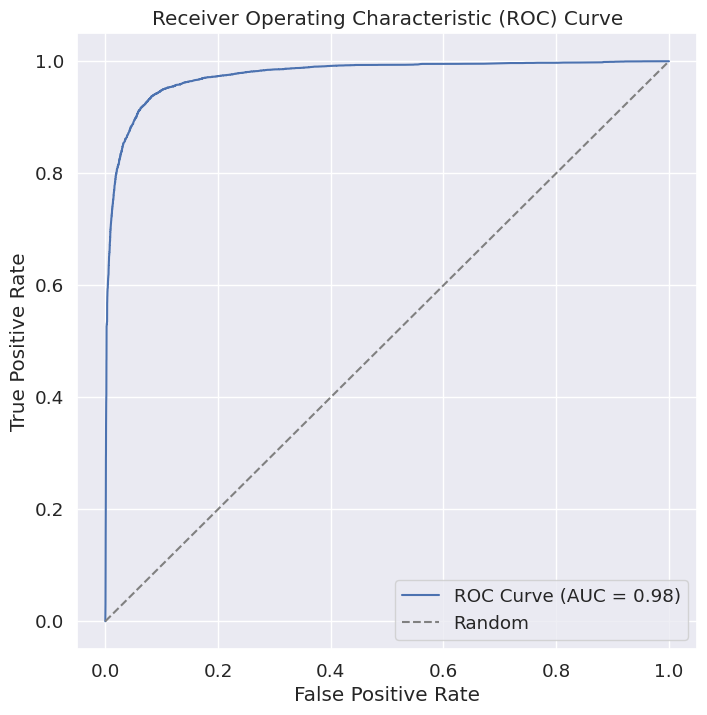

In [77]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(all_targets.cpu().numpy(), np.array(pdFas[1].tolist()))


roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

MulticlassConfusionMatrix()


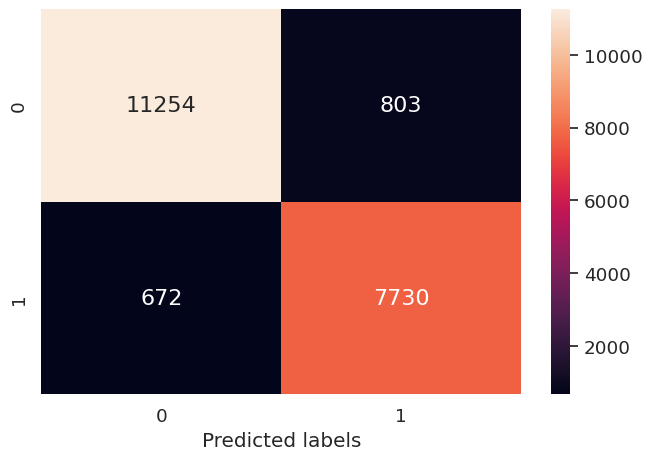

In [78]:
#confusion matrix
        
confusion_matrix_tb = ConfusionMatrix(num_classes=2, task='multiclass')
confusion_matrix_tb(all_preds.cpu(), all_targets.cpu())

print(confusion_matrix_tb)

computed_confusion = confusion_matrix_tb.compute().detach().cpu().numpy().astype(int)

df_cm = pd.DataFrame(
    computed_confusion,
)

fig, ax = plt.subplots(figsize=(10, 5))
fig.subplots_adjust(left=0.05, right=.65)
sns.set(font_scale=1.2)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d', ax=ax)
ax.set_xlabel('Predicted labels')
plt.show()




In [79]:
f1(all_preds.cpu(), all_targets.cpu())

tensor(0.9280)

In [ ]:
pdF = pd.DataFrame(all_preds.tolist(), all_targets.tolist())

In [ ]:
pdF.to_csv('preds.csv')